In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_7660/477056521.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
# path = os.path.join("grad_results/mnist_monolithic_numtrain_64_contrastive/mnist/monolithic/seed_0/agent_0",
#                     "sharing_record.csv")
# df = pd.read_csv(path)
# df.head()

path = "grad_new_results_divergence.csv"
df = pd.read_csv(path)
df.head()

,task_id,communication_round,time,algo,dataset,use_contrastive,avg_params,avg_params_stderr,avg_params_std
0,0,0,0,modular,fashionmnist,True,0.004586,0.000031,0.000178
1,0,0,0,modular,kmnist,True,0.004823,0.000041,0.000231
2,0,0,0,modular,mnist,True,0.004868,0.000036,0.000206
3,0,0,0,monolithic,fashionmnist,True,0.020490,0.000794,0.004492
4,0,0,0,monolithic,kmnist,True,0.026055,0.000378,0.002136


In [3]:
def get_magma_colors(total_elements):
    start = 0.2
    stop = 0.8
    cm_subsection = np.linspace(start, stop, total_elements)
    return [matplotlib.cm.plasma(x) for x in cm_subsection]

In [4]:
# get unique algo, dataset, and use_contrastive
algo_list = df["algo"].unique()
dataset_list = df["dataset"].unique()
use_contrastive_list = df["use_contrastive"].unique()

algo_list, dataset_list, use_contrastive_list

(array(['modular', 'monolithic'], dtype=object),
 array(['fashionmnist', 'kmnist', 'mnist'], dtype=object),
 array([ True]))

In [5]:
len(algo_list) * len(dataset_list) * len(use_contrastive_list)

6

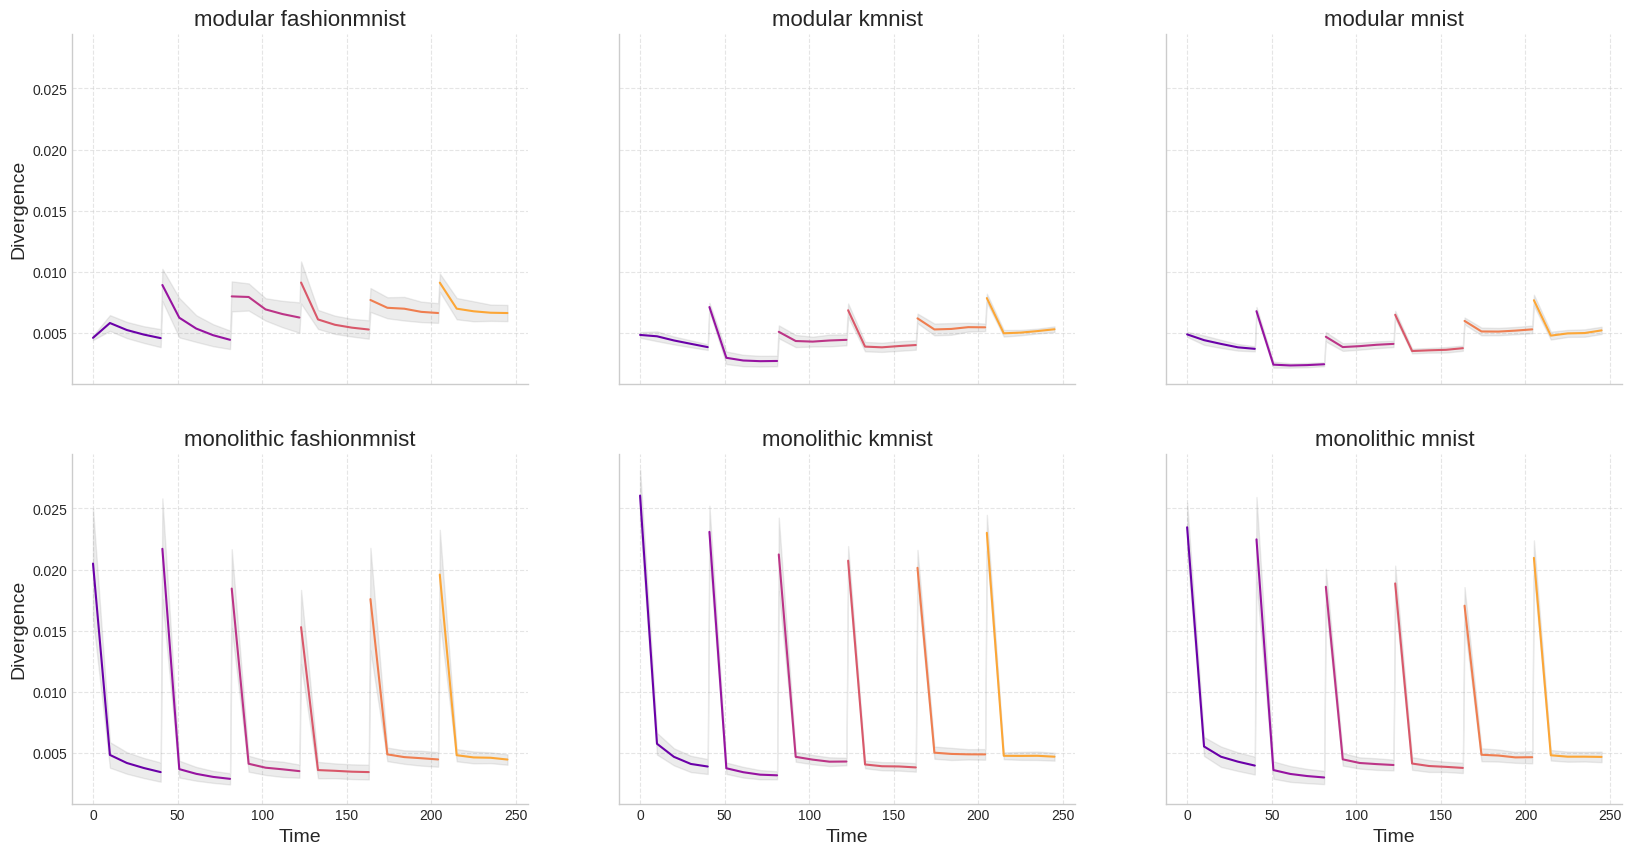

In [8]:

# take one combination of algo, dataset, and use_contrastive,
# and make df_one



# Create a plot with colored and labeled data points
# var = "avg_params_stderr"
var = "avg_params_std"
fig, axs = plt.subplots(figsize=(20, 10), nrows=2, ncols=3, sharex=True, sharey=True)
axs = axs.ravel()
plot_count = 0
for algo in algo_list:
        for dataset in dataset_list:
                for use_contrastive in use_contrastive_list: 
                        ax = axs[plot_count]
                        plot_count +=1
                        df_one = df[(df["algo"] == algo) & (df["dataset"] == dataset) & (df["use_contrastive"] == use_contrastive)]
                        num_colors = len(df_one['task_id'].unique())

                        colors = get_magma_colors(num_colors)

                        for i, (task_id, group) in enumerate(df_one.groupby('task_id')):
                                line = group.plot(x='time', y='avg_params', ax=ax,
                                label=i,
                                color=colors[i],
                        )

                        ax.fill_between(df_one['time'], df_one['avg_params'] - df_one[var], df_one['avg_params'] + df_one[var], 
                                        alpha=0.15, color='grey')
                        ax.get_legend().remove()
                        ax.set_xlabel("Time", fontsize=14)
                        ax.set_ylabel("Divergence", fontsize=14)
                        ax.set_title(f"{algo} {dataset}", fontsize=16)
                        ax.grid(True, which='major', linestyle='--', alpha=0.5)
                        ax.spines['top'].set_visible(False)
                        ax.spines['right'].set_visible(False)

plt.savefig("Figures/grad/divergence.pdf", bbox_inches='tight')